In [63]:
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import csv
import pandas as pd
from tqdm import tnrange, tqdm
from datetime import datetime
import xlwt
import multiprocessing
from xlwt import Workbook
import json
from collections import defaultdict
get_ipython().run_line_magic('matplotlib', 'notebook')
import matplotlib.pyplot as plt

class Ising():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def mcmove(self, config, N, beta, h):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    a = np.random.randint(1, N-1)
                    b = np.random.randint(0, N)
                    c = np.random.randint(0, N)
                    if a == len(config) :
                        s =  config[a, b, c]
                        nb = config[(a+1)%N,b,c] + config[a,(b+1)%N,c] + config[(a-1)%N,b,c] + config[a,(b-1)%N,c] + config[a,b,(c+1)%N] + config[a,b,(c-1)%N] - h 
                        cost = 2*s*nb
                    elif a == 0:
                        s =  config[a, b, c]
                        nb = config[(a+1)%N,b,c] + config[a,(b+1)%N,c] + config[(a-1)%N,b,c] + config[a,(b-1)%N,c] + config[a,b,(c+1)%N] + config[a,b,(c-1)%N] + h 
                        cost = 2*s*nb
                    else :
                        s =  config[a, b, c]
                        nb = config[(a+1)%N,b,c] + config[a,(b+1)%N,c] + config[(a-1)%N,b,c] + config[a,(b-1)%N,c] + config[a,b,(c+1)%N] + config[a,b,(c-1)%N]
                        cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-1*cost*beta):
                        s *= -1
                    else:
                        s *= 1
                    config[a, b, c] = s
        return config  
    
    def configPlot(self, f, config, i, N, n_):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N+1), range(N+1))
        sp =  f.add_subplot(1, 1, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i); plt.axis('tight')    
    plt.show()
    
    def calcEnergy(self, config, h):
        '''Energy of a given configuration'''
        N = len(config)
        energy = 0
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    if i == N:
                        S = config[i,j,k]
                        config[(a+1)%N,b,c] + config[a,(b+1)%N,c] + config[(a-1)%N,b,c] + config[a,(b-1)%N,c] + config[a,b,(c+1)%N] + config[a,b,(c-1)%N]
                        nb = config[(i+1)%N, j, k] + config[i,(j+1)%N, k] + config[(i-1)%N, j, k] + config[i,(j-1)%N, k] + config[i,j,(k+1)%N] + config[i,j,(k-1)%N] + h
                        energy += -nb*S
                    elif i == 0:
                        S = config[i,j,k]
                        nb = config[(i+1)%N, j, k] + config[i,(j+1)%N, k] + config[(i-1)%N, j, k] + config[i,(j-1)%N, k] + config[i,j,(k+1)%N] + config[i,j,(k-1)%N] - h
                        energy += -nb*S
                    else :
                        S = config[i,j,k]
                        nb = config[(i+1)%N, j, k] + config[i,(j+1)%N, k] + config[(i-1)%N, j, k] + config[i,(j-1)%N, k] + config[i,j,(k+1)%N] + config[i,j,(k-1)%N] 
                        energy += -nb*S
        return energy/6.


    def calcMag(self, config):
        '''Magnetization of a given configuration'''
        mag = np.sum(config)
        return mag
    
    def InteractionTop(self, config, N):
        '''Interaction energy of the top surface'''
        count=[[0]*N]*N
        for j in range(N):
            for k in range(N):
                count[j][k] = config[N-1,j,k]*config[N-2,j,k]
        count1 = np.array(count)    
        return (-1*count1)

    def InteractionBottom(self, config, N):
        '''Interaction energy of the bottom surface'''
        count=[[0]*N]*N
        for j in range(N):
            for k in range(N):
                count[j][k] = config[0,j,k]*config[1,j,k]
        count1 = np.array(count)    
        return (-1*count1)
    
    def CorrelationTop(self, Top, N, i, j):
        Correlation_Parallel = []
        Correlation_Diagonal = []
        for k in range(N/2):
            Correlation_Parallel.append((Top[i+k,j] + Top[i-k,j] + Top[i,j+k] + Top[i,j-k])/4)
            Correlation_Diagonal.append((Top[i+k,j+k] + Top[i-k,j+k] + Top[i-k,j+k] + Top[i-k,j-k])/4)
        return(Correlation_Diagonal, Correlation_Parallel)
    
    def CorrelationTop(self, Bottom, N, i, j):
        Correlation_Parallel = []
        Correlation_Diagonal = []
        for k in range(N/2):
            Correlation_Parallel.append((Bottom[i+k,j] + Bottom[i-k,j] + Bottom[i,j+k] + Bottom[i,j-k])/4)
            Correlation_Diagonal.append((Bottom[i+k,j+k] + Bottom[i-k,j+k] + Bottom[i-k,j+k] + Bottom[i-k,j-k])/4)
        return(Correlation_Diagonal, Correlation_Parallel)
    
    def average(self, a):
        count = 0
        for i in range(len(a)):
            count += a[i]
        count /= len(a)
        return(count)

    def convert_np(data):
        final_data=defaultdict(dict)
        for k1,v1 in data.items():
            for k2,v2 in v1.items():
                temp=[]
                for each in v2:
                    temp.append(np.asarray(each))    
                final_data[int(k1)][int(k2)]=tuple(temp)
            
        return final_data  
            
    
    with open('C:/Users/DEV KAKKAD/Desktop/Academics/SEM 7/Project - MonteCarlo/data.json') as f:
        points_data = json.load(f, parse_int=int)        
            
    points_data=convert_np(points_data)
    
    def get_xy():
        for density, scales_data in points_data.items():
            for scale,corros_points in scales_data.items():
                for each_line in corros_points:
                    for x in each_line[0]:
                        for y in each_line[1]:
                            pass
                        print(str(x)+", "+str(y)) 
                    
    with open('C:/Users/DEV KAKKAD/Desktop/Academics/SEM 7/Project - MonteCarlo/data.json') as f:
        points_data = json.load(f, parse_int=int)  
    
    densities=list(points_data.keys())

    densities    
    
    def simulate(self):   
        
        ''' This module simulates the Ising model'''
        
        '''Defining all parameters'''
        
        N = 4      # Number of Rows
        h = 0        #external field
        N_intermediate_points = 1       #  number of temperature points
        T_min = 1.40                         #  lower range for temperature
        T_max = 2.10                         #  upper range for temperature
        #T = np.linspace(T_min, T_max, N_intermediate_points);      #divisions T min and T max into different temperature steps 
        T = 1.8
        msrmnt = 10001
        DeltaPsi1 = []
        DeltaPsi2 = []
        DeltaPsi3 = []
        DeltaPsi4 = []
        Magnetization = [[0]*1000]*1000
        Energy = []
        iteration = []
        Correlation_Parallel = []
        Correlation_Diagonal = []
        iteration = []
     
        #----------------------------------------------------------------------------------
        
        '''generating the solid-liquid system'''
        
        config = 2*np.random.rand(N,N,N)-1
        
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    if i!=0 and i!=N-1:
                        config[i,j] = 1.0
        
        #print(config)
        
        '''code for heterogeneous surface
        
        with open('C:/Users/DEV KAKKAD/Desktop/Academics/SEM 7/Project - MonteCarlo/data.json') as f:
            points_data = json.load(f, parse_int=int)
        
        for each_line in points_data['64032']['1']:
            print(each_line)
            for x in each_line[0]:
                for y in each_line[1]:
                    config[0,x,y] = -0.1
                    config[N-1,x,y] = -0.1'''
            

            
        '''Plotting the solid surface for visualisation'''
        
        surface = 2*np.random.rand(N,N)-1
        for i in range(N):
            for j in range(N):
                surface[i,j] = config[0,i,j]
        print(surface)
        
        f = plt.figure(figsize=(8, 8), dpi=80);
        
        self.configPlot(f, surface, 0, N, 1);

        '''Data Calculation'''
        
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0/T, h)
                
            if i%100 == 0:
                DeltaPsi1.append((np.sum(self.InteractionBottom(config, N)) + np.sum(self.InteractionTop(config, N)))/2)
                Energy.append(self.calcEnergy(config, h))
                iteration.append(i)
                
                for j in range(N):
                    Magnetization[j][int(i//100)] = np.sum(config[j,:,:])
        
        psi1 = self.average(DeltaPsi1)
        for i in range(len(DeltaPsi1)):
            DeltaPsi2.append((DeltaPsi1[i]-psi1)**2)
            DeltaPsi3.append((DeltaPsi1[i]-psi1)**3)
            DeltaPsi4.append((DeltaPsi1[i]-psi1)**4)
            
        psi2 = self.average(DeltaPsi2)
        psi3 = self.average(DeltaPsi3)
        psi4 = self.average(DeltaPsi4)
        
        print(round(psi1,4), round(psi2, 4), round(psi3, 4), round(psi4, 4))
        
        f = plt.figure(figsize=(9, 5)); # plot the calculated values

        plt.scatter(iteration, Energy, s=50, marker='o', color='IndianRed')
        plt.axis([T_min-0.2, T_max+0.2, -0.0023, 0])
        plt.xlabel("Iteration", fontsize=20);
        plt.ylabel("Energy", fontsize=20);         plt.axis('tight');
        
        Bottom = self.InteractionBottom(config, N)
        Top = self.InteractionTop(config, N)
        
        


[[ 0.20469877  0.93904793  0.12804757 -0.86873035]
 [-0.84998072 -0.5770344  -0.98558553 -0.19951861]
 [-0.45391789 -0.40140576  0.6499183  -0.54747597]
 [ 0.73097829  0.31053465 -0.40592642  0.46667986]]


<IPython.core.display.Javascript object>


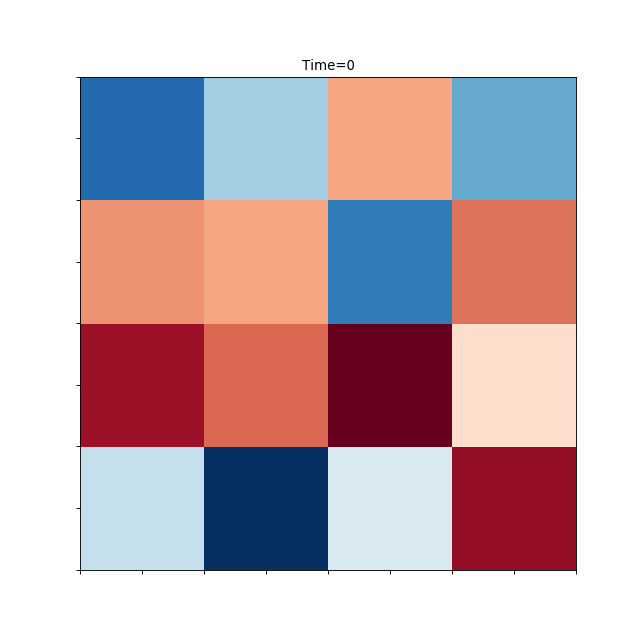

-2.1462 0.0299 0.0357 0.0435


<IPython.core.display.Javascript object>


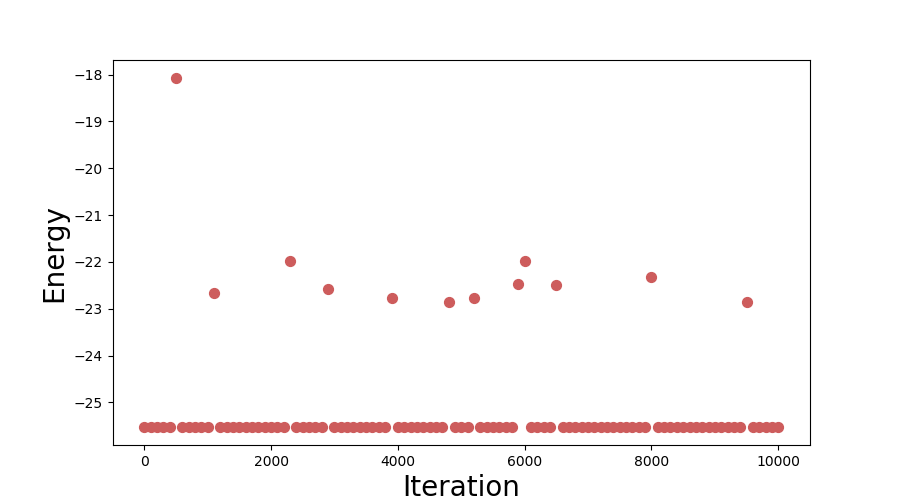

[[ 0.60931018  0.52889594  0.14315164  0.5350809 ]
 [-0.39685308  0.18425968 -0.69788429 -0.04446049]
 [ 0.91485636 -0.49620712 -0.78570702  0.13175385]
 [-0.37080512 -0.35102039  0.13769013 -0.89915764]]


<IPython.core.display.Javascript object>


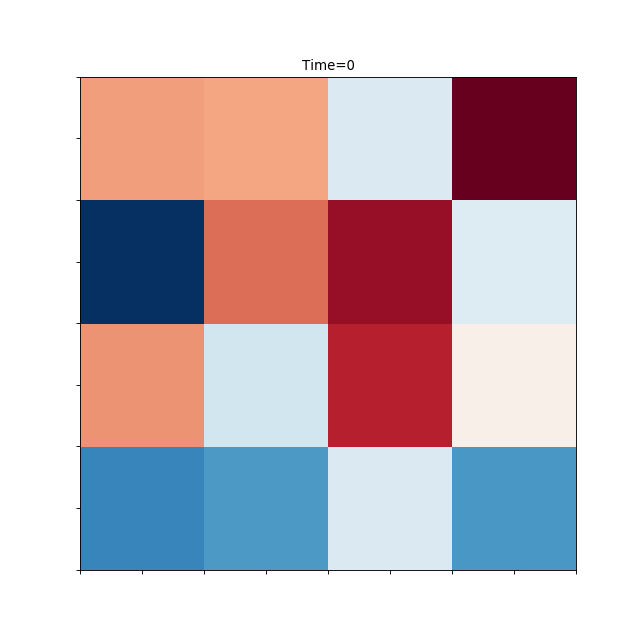

4.0564 0.4631 -1.5029 5.4269


<IPython.core.display.Javascript object>


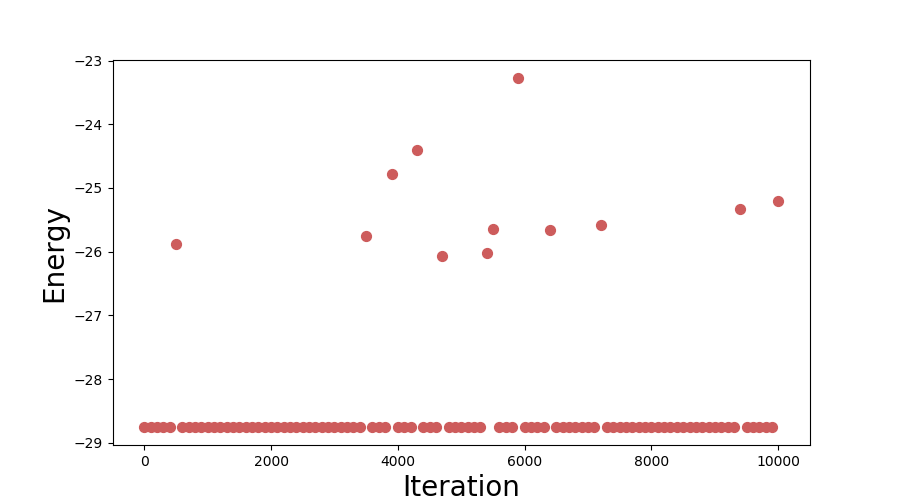

[[ 0.03036687  0.02786784 -0.41264181 -0.8730129 ]
 [-0.90485263  0.58657776 -0.96832148 -0.98254676]
 [ 0.66417273 -0.22214381  0.11453561  0.89801306]
 [ 0.71723644 -0.97224118 -0.95346387  0.30345061]]


<IPython.core.display.Javascript object>


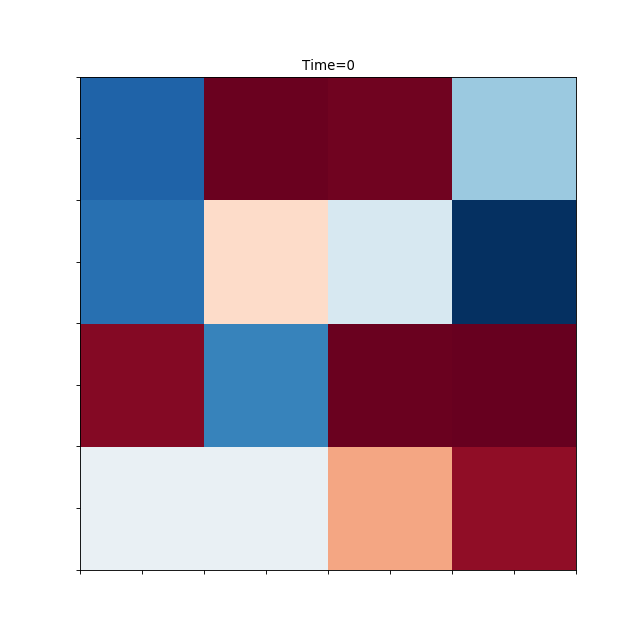

1.768 0.4616 -1.5524 5.6045


<IPython.core.display.Javascript object>


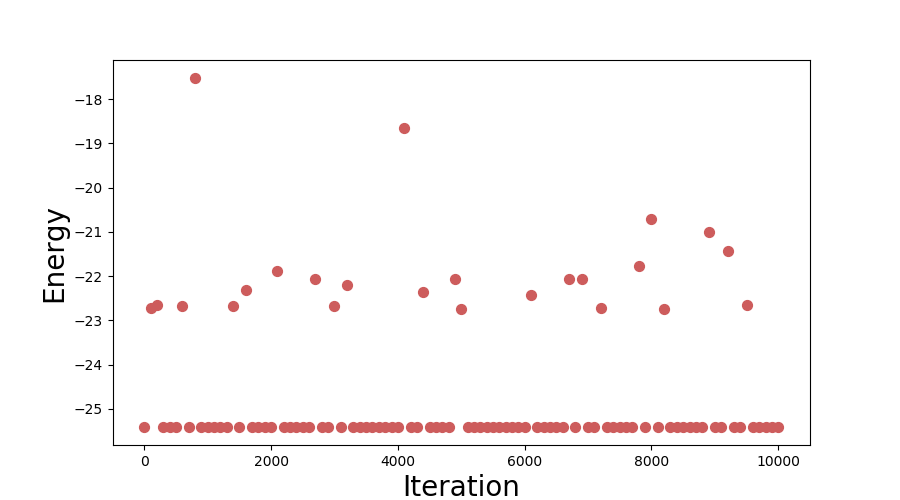

[[-0.1650624  -0.13159867  0.48603983  0.77488745]
 [-0.20624715  0.46867236 -0.1321617  -0.44820751]
 [-0.69720518  0.05011949 -0.110772    0.33625965]
 [ 0.96278863 -0.84348734 -0.73348942  0.1314283 ]]


<IPython.core.display.Javascript object>


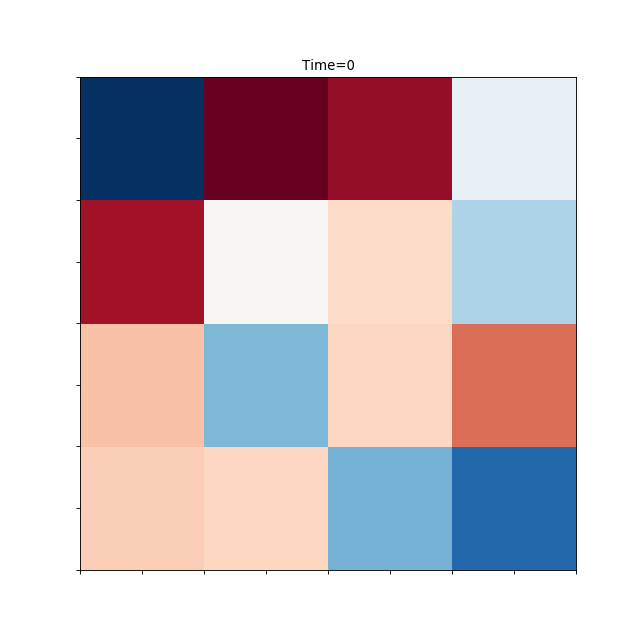

-0.2694 0.1598 -0.0443 1.2957


<IPython.core.display.Javascript object>


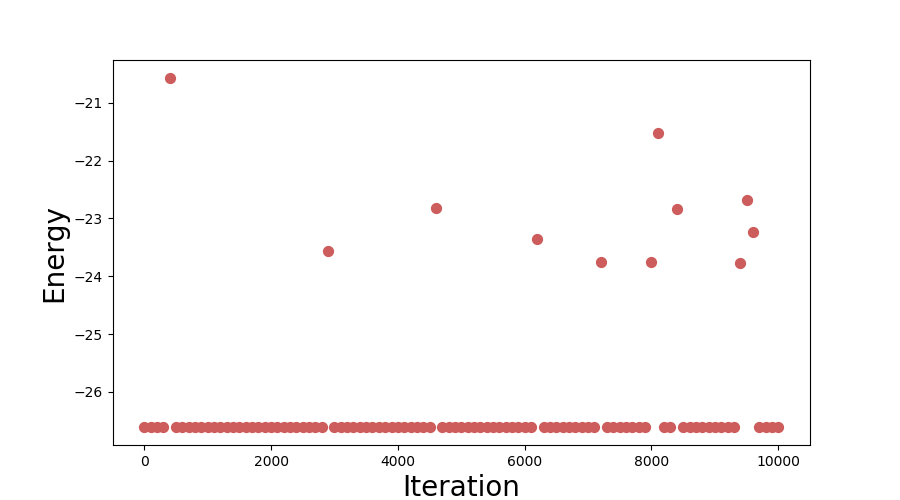

[[-0.59885745  0.34391291 -0.87915249  0.41007006]
 [ 0.63076936 -0.67705865 -0.79540583 -0.09126767]
 [-0.90987564  0.40263993  0.43863812  0.70184289]
 [ 0.23849053 -0.91941008 -0.84961194 -0.69394318]]


<IPython.core.display.Javascript object>


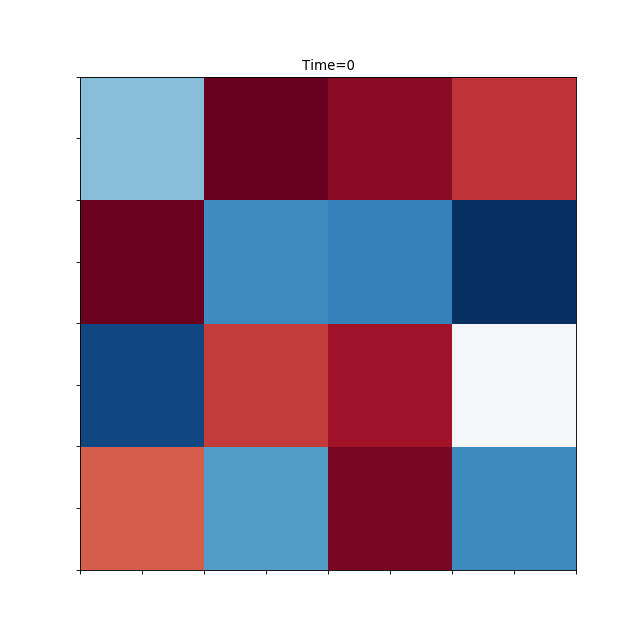

1.6149 0.3144 0.1819 3.8586


<IPython.core.display.Javascript object>


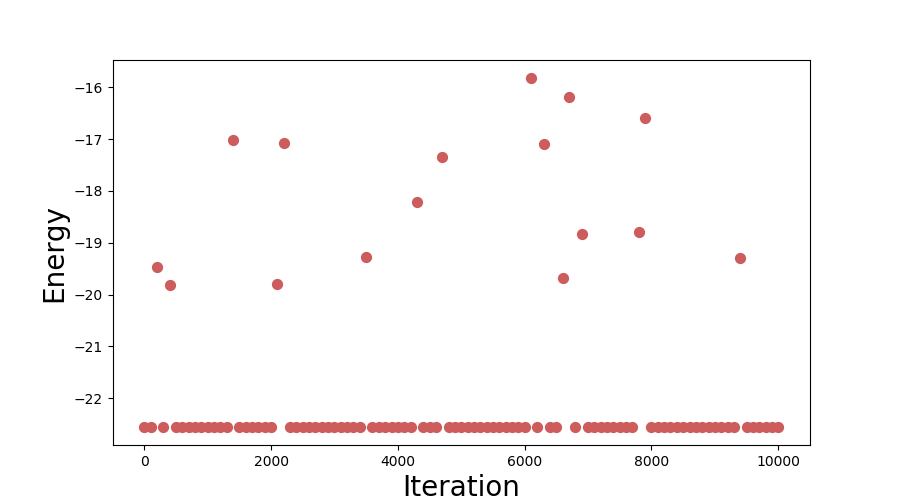

[[ 0.17627175 -0.21337775 -0.99630426 -0.21876119]
 [ 0.75400479  0.31235608 -0.94472657  0.34843065]
 [ 0.63861868  0.94326528 -0.42361264 -0.51998581]
 [ 0.325705   -0.13753751  0.53303109 -0.98334748]]


<IPython.core.display.Javascript object>


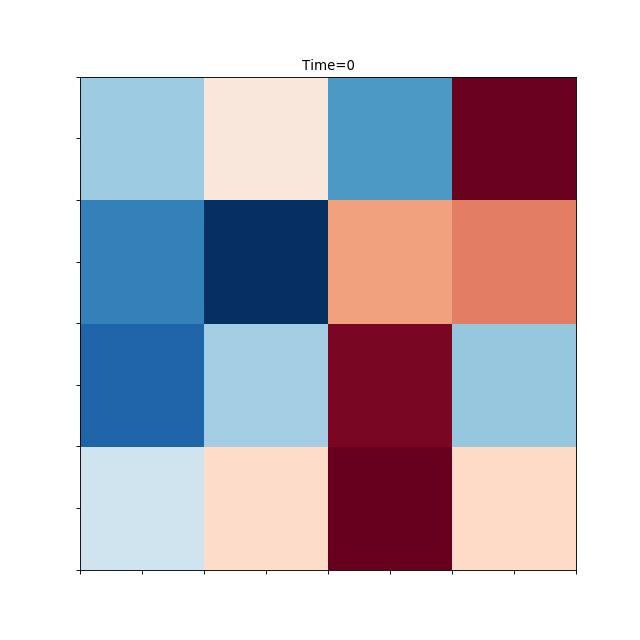

2.866 0.3207 -0.8 3.4062


<IPython.core.display.Javascript object>


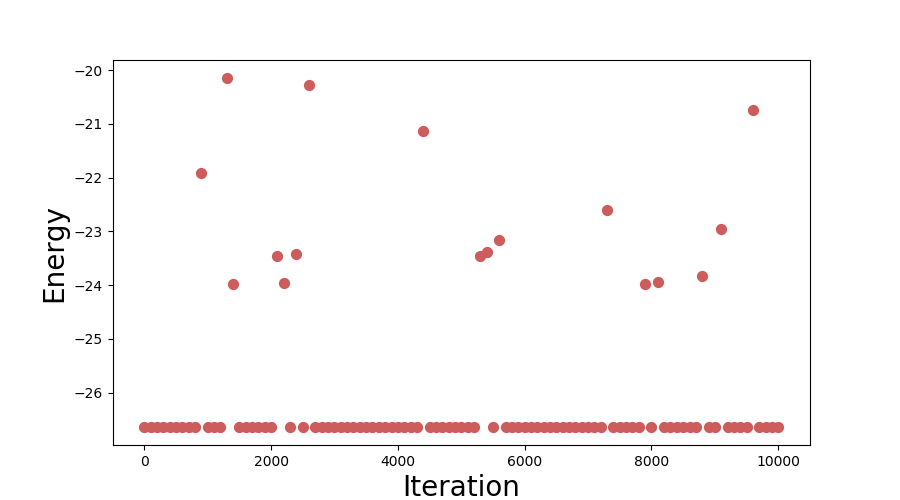

[[-0.60721284  0.69952163 -0.38735572  0.65316373]
 [ 0.53546556  0.35730778  0.87873166 -0.62282266]
 [-0.36798957 -0.11652009 -0.24341704 -0.70559021]
 [-0.02473063  0.57824385 -0.21719716  0.65051377]]


<IPython.core.display.Javascript object>


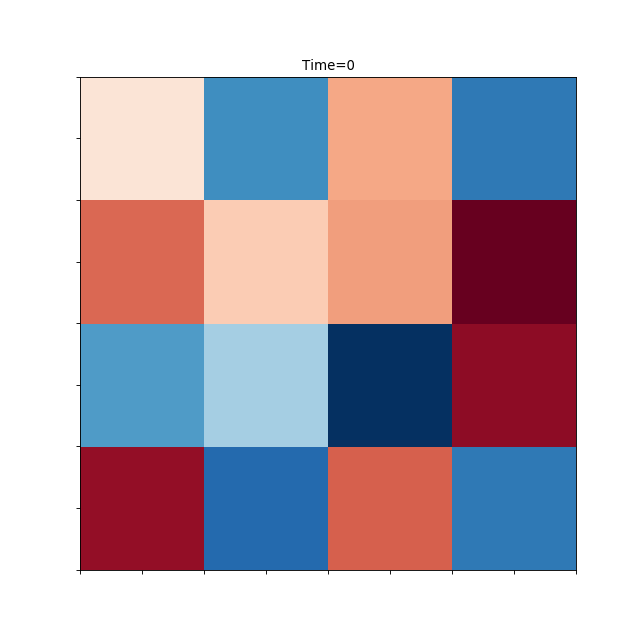

-0.963 0.4104 -1.37 4.841


<IPython.core.display.Javascript object>


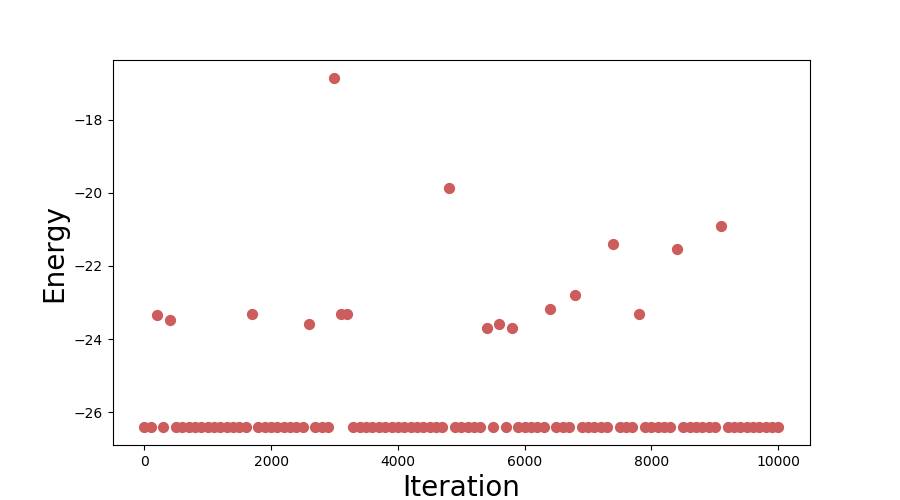

[[ 0.69989334 -0.56918014 -0.74346977 -0.22000434]
 [ 0.37632908  0.52818625 -0.61367711  0.71597934]
 [ 0.65008099 -0.90473895  0.09601346 -0.98235017]
 [-0.33486357 -0.41767812  0.07985601  0.19782554]]


<IPython.core.display.Javascript object>


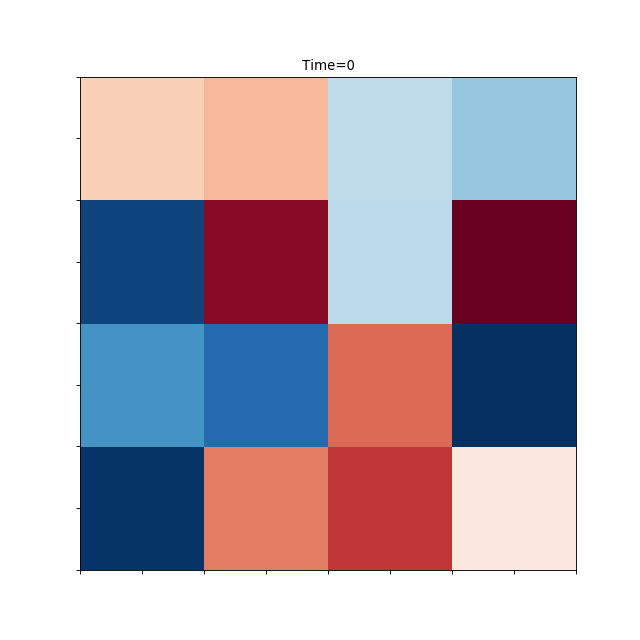

2.192 0.0943 -0.2013 0.4415


<IPython.core.display.Javascript object>


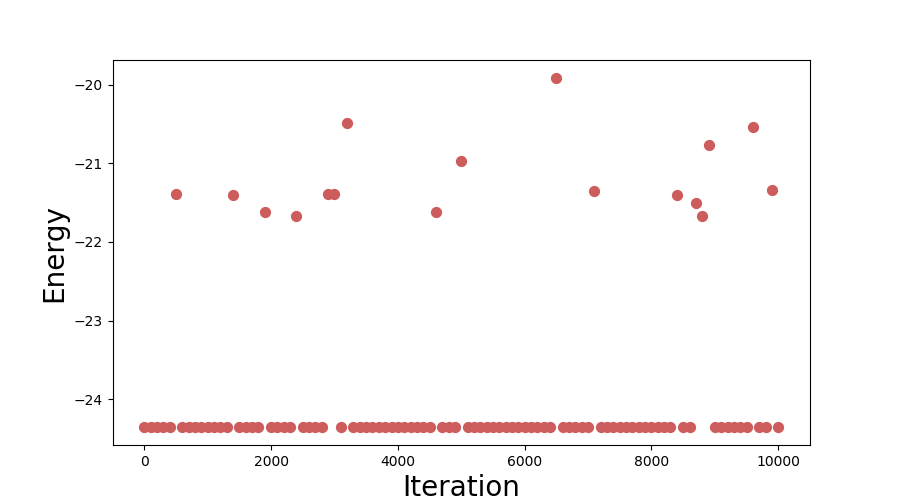

[[-0.26884816 -0.31330024  0.44743843  0.01700646]
 [ 0.03290871  0.14170015 -0.05623657  0.91332705]
 [-0.05869092 -0.7782904   0.87611244  0.34430131]
 [-0.9544087  -0.08579355 -0.2762032   0.31852207]]


<IPython.core.display.Javascript object>


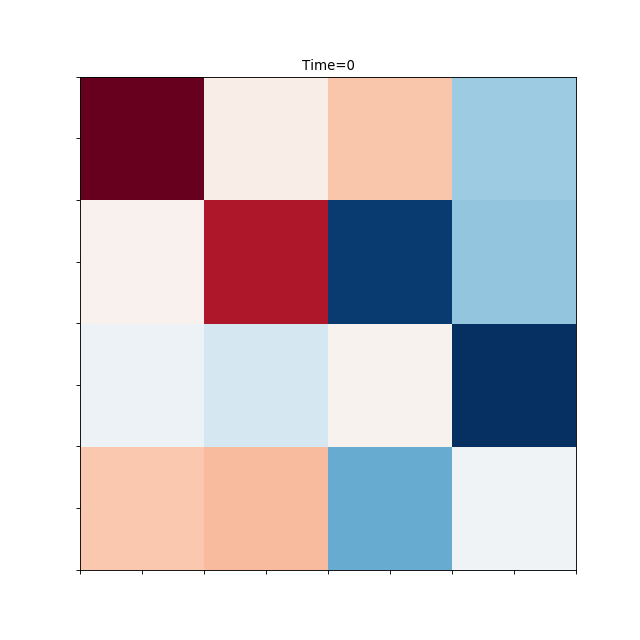

3.086 0.2903 -1.0356 3.8495


<IPython.core.display.Javascript object>


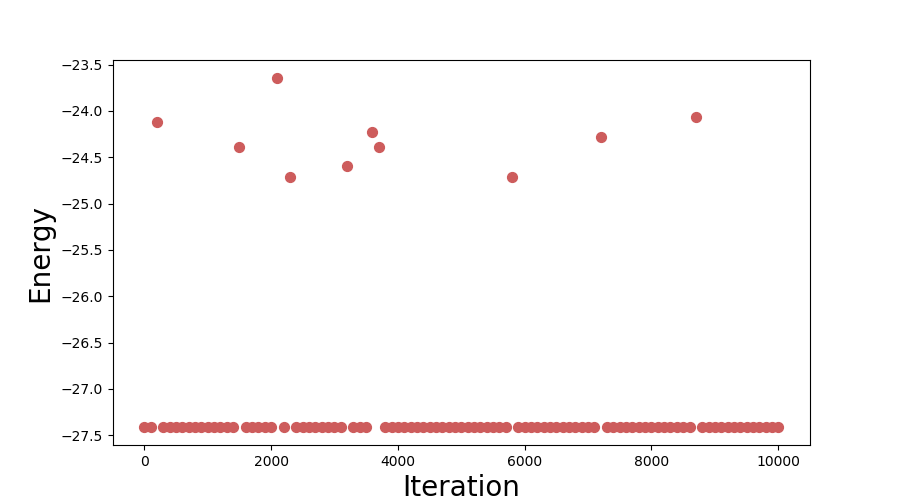

[[ 0.58913987  0.38943614  0.5710035   0.56469567]
 [ 0.25994834 -0.86269698 -0.68243981 -0.38526011]
 [-0.13514901  0.1777644   0.38962654 -0.55272382]
 [ 0.47854021 -0.67795631 -0.37899298  0.62434227]]


<IPython.core.display.Javascript object>


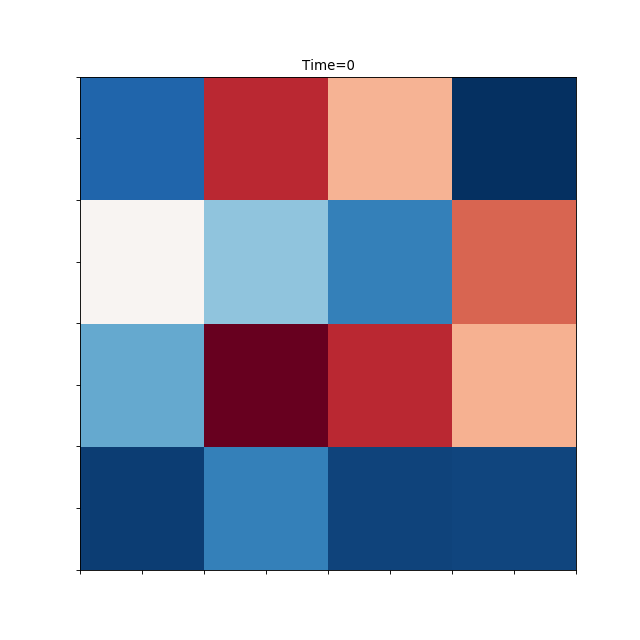

-0.4096 0.1207 -0.1164 0.6834


<IPython.core.display.Javascript object>


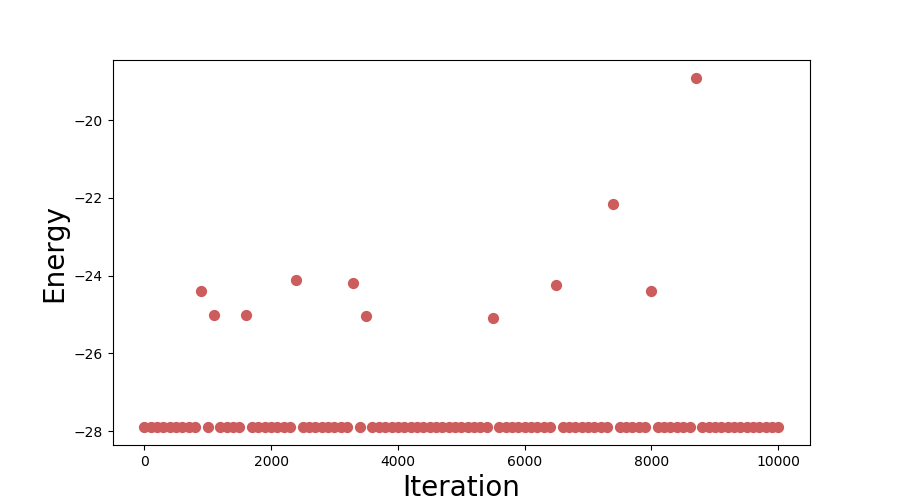

In [64]:
import multiprocessing

rm = Ising()

processes = []

for _ in range(10):
    p = multiprocessing.Process(target=rm.simulate())
    p.start
    processes.append(p)
    